# Music Genre and Composer Classification Using Deep Learning

## Classical Music Time Series Model Comparison
## AAI-511 Team 6 Final Project
## Part I : Data Preprocessing & Feature Extraction

Team 6:  Philip Felizarta, Sarah Durrani, Geoffrey Fadera

University of San Diego, Applied Artificial Intelligence

Date:  August 12, 2024

GitHub Repository: https://github.com/PhilipFelizarta/Classical-Music-Time-Series-Model-Comparison?query=PhilipFelizarta

In [17]:
import os
import pretty_midi
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import zipfile
import pandas as pd
import warnings
import pickle
from sklearn.preprocessing import LabelBinarizer
import warnings
from visual_midi import Plotter, Preset
import matplotlib.pyplot as plt

RANDOM_STATE = 0
TRAIN_SIZE = 0.80
VAL_TEST_SPLIT = 0.5

## Supporting Functions

In [ ]:
# Unzip file and all zipped files within all its subdirectory levels
# By visual inspection, even after unzipping the parent directory 'archive', composers' subdirectories still contain Zip files.
# The following function unzips a Zip file, and recursively unzips all Zip files within it.

def unzipFileTree(directory, file):
    
    if file.endswith('.zip'):
        zip_filepath = os.path.join(directory, file)
        zip_filename = os.path.splitext(os.path.basename(zip_filepath))[0]
        zip_targetDir = os.path.join(directory, zip_filename)
        
        try:
            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                zip_ref.extractall(zip_targetDir)
                #print(f"\tUnzipped File: {zip_filepath}")
                #print(f"\tUnzipped to folder: {zip_targetDir}")
        except zipfile.BadZipFile:
            print(f"Error: {zip_filepath} is a bad zip file")
    else:
        return

    for root, dirs, files in os.walk(zip_targetDir):
        for file in files:
            unzipFileTree(root, file)


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Read midi files under each 'composer' folder
# Input: root directory, composer string array
# Return: [List of imported prettyMidi files, List of corresponding composer]

def read_Midis_Composer (directory, composers = []):
    
    midis_data = []
    composer_data = []
    filepath_data = []

    for composer in composers:
        composerDir = os.path.join(directory, composer)
        
        for dirpath, dirs, files in os.walk(composerDir):  
            for filename in files: 
                fname = os.path.join(dirpath,filename) 
                
                try:
                   # with warnings.catch_warnings():
                   # warnings.simplefilter("error")
                    pm = pretty_midi.PrettyMIDI(fname)

                except:
                    if (fname.endswith('.mid') or fname.endswith('.MID')): 
                        print(f"Error loading MIDI file (Skipping):", fname)
                    else : 
                        print(f"Warning: Non-midi file encountered (Skipping):", fname)
                    continue
                
                # make all extensions ''.mid'
                
                
                base_name, _ = os.path.splitext(fname)
                new_fname = base_name + ".mid"
                os.rename(fname, new_fname)
                
                
                midis_data = np.append(midis_data, pm)
                composer_data = np.append(composer_data, composer)
                filepath_data = np.append(filepath_data, new_fname)
    
    return midis_data, composer_data, filepath_data

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# define a function that converts a pretty_midi array into a 'bag of notes'
# Dimensionality is reduced as Time and Instrument components are now added as features for each note.

def convertMidisList_OP1 (midisDataList = []):
    
    resultMidisList = []
    for midisData in midisDataList:
        
        flatMidi = []
        for instrument in midisData.instruments:
            for note in instrument.notes:
                start = note.start
                end = note.end  
                pitch = note.pitch
                velocity = note.velocity

                combinedEntry = np.array([start, end, pitch, velocity, instrument.program])
                flatMidi.append(combinedEntry)

        resultMidisList.append(np.array(flatMidi))

    return resultMidisList

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# parses flattened pretty_midi data (OPTION 1) and
# returns list of notes simultaneously being played at input timestamp

def sample_FlatMidi(midiFlat=[], timestamp=0):
    
    startTime_col = 0
    endTime_col = 1

    rows = (midiFlat[:, startTime_col] < timestamp) & (midiFlat[:, endTime_col] >= timestamp)
    selected_rows = midiFlat[rows]

    return selected_rows   

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Converts a flattened midi file (from OPTION 1) into a time-sequence of 2-D vectors
# each vector is of shape (Max Number of Notes Sampled in this midi at any time instance) X 3.

def convertFlatMidi_OP2(midiFlatOP1=[], Fs = 10):
    
    start = 0
    stop = np.max(midiFlatOP1[:,1])
    step = 1/Fs
    timeline = np.arange(start, stop + step, step)
    resultMidi = []
    maxNotesOneSample = 0
    
    # sample the flattened Midi at a given timestamp. save notes played simultaneously at that time instance.
    # remove start and end time attributes.
    for timestamp in timeline:
        sampledNotes = sample_FlatMidi(midiFlatOP1, timestamp)
        
        if len(sampledNotes) > maxNotesOneSample:
            maxNotesOneSample = len(sampledNotes)
        
        resultMidi.append(sampledNotes[:,2:5])
    
    # pad samples so final array is of size (Max Num of simultaneous Notes played at one time instance) X 3
    for i in range(0, len(resultMidi)):
        sample = resultMidi[i]
        samplePadded = np.pad(sample,((0, maxNotesOneSample - sample.shape[0]), (0, 0)), mode = 'constant')
        resultMidi[i] = samplePadded
    
        
    return np.array(resultMidi), maxNotesOneSample

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Converts flattened Midi List from OP1 into time-series representation
# Each midi from the output of OP1 is sampled given Fs (number of samples per second)
# 

def convertFlatMidisList_OP2 (midisFlatList_OP1=[], Fs = 10):
    resultMidisList = []
    resultMidisListPadded = []
    maxNotesPerSampleEntireList = 0
    
    for index, flatMidi in enumerate(midisFlatList_OP1):
        
        # convert each flattened Midi (from OP1) into (?,3) x time vector.
        flatMidi_OP2, maxNotesPerSampleThisMidi = convertFlatMidi_OP2(flatMidi, Fs)
        
        # store max number of notes simultaneously playing at any time instance during sampling.
        if (maxNotesPerSampleThisMidi > maxNotesPerSampleEntireList ):
            maxNotesPerSampleEntireList = maxNotesPerSampleThisMidi
            #print("Num simultaneous notes now at: ", maxNotesPerSampleEntireList)
            #print("Encountered at input no: ", index)
        
        # append converted midi to final list
        resultMidisList.append(flatMidi_OP2)
     
    # At this point, return List is 4-D:
    # (NUMBER OF INPUT MIDIs) X (? NUMBER OF TIME SAMPLES) X (? Number of Sampled Notes per Midi) X 3 (Note)
    # pad third dimension with zeros to match max number of sampled notes
    
    for i in range(0, len(resultMidisList)):
        
        # (time samples) x (max number of simultaneous notes for this midi) x 3
        midi = resultMidisList[i]
        
        # pad zeros on the second dimension to match max number of simultaneous notes for entire list
        midiPadded = np.pad(midi,((0,0), (0, maxNotesPerSampleEntireList - midi.shape[1]), (0, 0)), mode = 'constant')

        resultMidisListPadded.append(np.array(midiPadded))

    #return resultMidisList resultMidisListPadded, maxNotesPerSampleEntireList
    return resultMidisListPadded, maxNotesPerSampleEntireList

## Step 1. Data Import, Clean-Up, Exploratory Analysis, Pre-processing

In [ ]:
# (1.1) Place 'archive.zip' in the same folder as this ipynb file and unzip using unzipFileTree () function.
unzipFileTree('./', 'archive.zip')

In [ ]:
# (1.2) Define root directory of midi files to be processed
# Define composers to analyze
# Import midi files into a list, and generate a list of corresponding composer labels using the read_Midis_Composer() function

ROOT = "./archive/midiclassics"
COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

midisData, composersData, midiFilePathsData = read_Midis_Composer(ROOT, COMPOSERS)
np.savez('Step1_midisData.npz', *midisData)
np.savez('Step1_composersData.npz', *composersData)
np.savez('Step1_midiFilePaths.npz', *midiFilePathsData)

In [ ]:
# (1.3) Observe shape of data, and composer distribution

print("midisData shape: ", midisData.shape)
print("composersData shape: ", composersData.shape)
print("midiFilePathsData shape: ", midiFilePathsData.shape)

pd.DataFrame(composersData).value_counts()

**NOTE:** There is clear class imbalance with the 'Bach' label having at least 4 times as many samples as the rest of the classes.

In [ ]:
# (1.4) Convert Labels (composersData) to Binary Representations

label_enc=[]
label_enc = LabelBinarizer()
composersDataBin = label_enc.fit_transform(composersData)
composersDataBin.shape

# save to file
with open('Step1_labelBinarizer.pkl', 'wb') as f:
    pickle.dump(label_enc, f)

np.savez('Step1_composersDataBin.npz', *composersDataBin)

## Step 2. Data Conversion to Suitable Formats

Various options are explored in converting the midi data to suitable formats for deep learning models.

**Option 1:** Flattened pretty midi Notes vectors "Bag of Notes"<br>
**Option 2:** Time-series of pretty midi Notes vector<br>
**Option 3:** Time-series of Features extracted from raw audio

### STEP 2.0: Background on Midi files and pretty_midi python Library. 

"MIDI files, short for Musical Instrument Digital Interface files, are a type of data file that contains instructions for musical performance rather than actual audio recordings. MIDI files are essentially a set of instructions that tell electronic instruments or software what notes to play, how long to play them, and how loudly". (Perplexity, 2024). The MIDI file format is standardized and can be found here: (https://midi.org/standard-midi-files)

Pretty_midi is a python library that parses a midi file and converts it into "a container for MIDI data in an easily-manipulable format." (https://craffel.github.io/pretty-midi/#pretty-midi-prettymidi). The container is a list of instruments, with each instrument containing a list of notes to be played.

For each **Instrument**, the most basic attributes are: 
> **program:** provides the numerical mapping to actual musical instrument.(https://fmslogo.sourceforge.io/manual/midi-instrument.html). <br>
> **notes:** provides a sequence of 'Notes' to be played by the instrument.<br>
> Each of these notes is a vector containing {start, end, pitch, and velocity} values (https://craffel.github.io/pretty-midi/#pretty_midi.Note).
>> **start:** absolute time in seconds when this note is to be played <br>
>> **end:** absolute time in seconds when playing of this note ends.<br>
>> **pitch:** integer representation of actual musical notes (values 0-127)<br>
>> **velocity:** integer representation of the loudness of this note (values 0-127)

Effectively, a pretty_midi file is a 3-D vector of the following shape:
>(num of instruments) x (num of 'Notes' per instrument) x [start, end, pitch, velocity]


In [ ]:
# For example, let us visualize one pretty_midi data
# The following only works for instrument program no 0 (piano)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    preset = Preset(plot_width=900)
    plotter = Plotter(preset, plot_max_length_bar=4)
    
    plotter.show_notebook(midisData[566])

![image](pretty_midivisual.png)

The plot above is a visualization of the pretty Midi data 'midisData[566]' (the shortest in time length). 
(Unfortunately, the visual_midi Plotter() function only works for one instrument program = 0)

It shows all the different "Notes" to be played across time. 
Each 'Note' is color coded and has a fixed time interval. 
Hovering the mouse over one 'Note' reveals a vector containing {program, pitch, velocity, duration, start_time, end_time}


### STEP 2.1 (OPTION 1): "BAG of NOTES" Conversion

Each midi file is converted into a collection of Note vectors where each vector contains [start, end, pitch, velocity, program]

Each imported midi file is converted:

From: 
> **shape:** (?, ?, 4) <br>
> **description:** (*num of instruments*) **X** (*num of Notes per instrument*) **X** (*NOTE vector:[start, end, pitch, velocity]*)

To:
> **shape:** (?, 5) <br>
> **description:** (*Number of new Note vectors*) **X** (*new NOTE vector:[start, end, pitch, velocity, program]*)

This flattens the pretty_midi vector along the 'instrument' dimension.<br>
Also, the Time component is part of each Note vector - i.e. 'start', 'end'.
The values are going to be directly used as features.


In [ ]:
# convert each pretty_midi data into a (None, 5) vector using convertMidisList_OP1() function
midisDataOP1 = convertMidisList_OP1(midisData)

# Save the list of arrays to a .npz file
np.savez('Step2_midisOP1.npz', *midisDataOP1)

**OPTION 1 SUMMARY:** midisDataOP1 is of shape (1635, ?, 5)
> **1635 :** total num midis <br>
> **? :** number of unique Note vectors per midi file. value not fixed. <br>
> **5 :** Note vector (start, end, pitch, velocity, instrument)


### STEP 2.2 (OPTION 2): Time-series representation.

#### Each midi file is converted into a vector (TIME INSTANCES) X (LIST OF NOTES TO BE PLAYED GIVEN TIME INSTANCE) X (NOTE Vector)

**{TIME INSTANCES}** entire time length of a midi file divided into time instances of uniform interval defined by 1/Fs

**{LIST OF NOTES TO BE PLAYED GIVEN TIME INSTANCE}** shape varies depending on Fs, midi file, etc. To maintain uniform shape along this dimension, this list is padded with zeros to match the maximum number of notes sampled at any given time across all midis.

Each **{NOTE Vector}** contains (pitch, velocity, instrument).  'start' and 'end' attributes are removed from OP1.

In [ ]:
# Define Fs, number of samples per second
# convert flattened midis from OP1 to time-series representation

Fs = 10
midisDataOP2, maxNotesAll = convertFlatMidisList_OP2(midisDataOP1, Fs)

In [ ]:
# Save the list of arrays to a .npz file
np.savez('Step2_midisOP2_Fs10.npz', *midisDataOP2)

In [ ]:
# 2 sample per second
midisDataOP2_Fs2, maxNotesAll = convertFlatMidisList_OP2(midisDataOP1, 2)
np.savez('Step2_midisOP2_Fs2.npz', *midisDataOP2_Fs2)

In [ ]:
# 5 sample per second
midisDataOP2_Fs5, maxNotesAll = convertFlatMidisList_OP2(midisDataOP1, 5)
np.savez('Step2_midisOP2_Fs5.npz', *midisDataOP2_Fs5)

**OPTION 2 SUMMARY:** midisDataOP2 is of shape (1635, ?, 36, 3)
> **1635 :** total num midis <br>
> **? :** evenly spaced time instances per midi. The length varies depending on Fs and the time length of the midi file  <br>
> **36 :** notes simultaneously played per time instance <br>
> **3 :** Note vector (pitch, velocity, instrument)

### STEP 2.3 (OPTION 3): Audio Conversion then Feature Extraction

#### 2.3.1 Data Collection
The data utilized in this project comprises musical scores, initially provided in MIDI format. MIDI files are a standard format for encoding musical compositions in a digital form, capturing information such as pitch, velocity, and timing of musical notes.
#### 2.3.2 Data Pre-processing
The raw MIDI files were converted into WAV format, enabling them to be processed for feature extraction. This conversion was crucial because deep learning models require a consistent, numerical input format. The conversion to WAV format allowed for the extraction of meaningful audio features, which served as inputs to the models.
#### 2.3.3 Feature Extraction
Feature extraction was a pivotal step in transforming the raw audio data into a format suitable for deep learning models. The features extracted include:
Mel Spectrogram: A representation of the power distribution over frequency bands, which captures the harmonic content of the audio.
Chroma Features: These features capture the pitch class distribution, representing the tonal content of the music.
Tempo: The tempo feature captures the speed of the music, which can vary significantly between different composers.
These features were extracted using the librosa library, a widely used tool in audio analysis and machine learning for music information retrieval . The extracted features were then flattened into feature vectors, which were used as inputs for the subsequent deep learning models.

In [ ]:
import os
import librosa
import numpy as np
from midi2audio import FluidSynth
import warnings

# Suppress specific warning from librosa
warnings.filterwarnings("ignore", category=UserWarning, module='librosa.core.pitch')

# Adjust the dataset path
dataset_dir = './content/Composer_Dataset/Composer_Dataset/NN_midi_files_extended'
output_wav_dir = './content/wav_files'
os.makedirs(output_wav_dir, exist_ok=True)


# Function to convert .mid to .wav (raw audio), using FluidR3_GM config, 
# Convert each Midi File to RAW Audio
def convert_midis_to_wavs(midiFilePaths, output_dir):
    
    wav_filePaths = []
    
    for i, midiFilePath in enumerate(midiFilePaths):
        # if .wav already exists for this .mid file, do not generate .wav file again
        wav_file = os.path.join(output_dir, os.path.basename(midiFilePath).replace('.mid', '.wav'))
        if os.path.exists(wav_file):
            print("File No: ", i,": audio already rendered. Skipping")
            wav_filePaths.append(wav_file)
            continue
        try:
            print("File No: ", i,": audio rendering")
            wav_filePaths.append(wav_file)
            fs = FluidSynth('/opt/homebrew/Cellar/fluid-synth/2.3.6/share/fluid-synth/sf2/FluidR3_GM.sf2')
            fs.midi_to_audio(midiFilePath, wav_file)
            
        except Exception as e:
            print(f"Error converting {midi_file} to WAV: {e}")
            return None
        
    return wav_filePaths


# Updated extract_audio_features function
def extract_audio_features(audio_file):
    try:
        y, sr = librosa.load(audio_file, sr=None)
        feature_vector = []
        
        # Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        log_mel_spectrogram_flat = log_mel_spectrogram.flatten()
        
        # Chroma features
        if np.any(y):  # Ensure the audio is not silent
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_stft_flat = chroma_stft.flatten()
        else:
            chroma_stft_flat = np.zeros((12 * log_mel_spectrogram.shape[1],))

        # Tempo
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        if len(onset_env) > 0:
            tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
            if isinstance(tempo, np.ndarray):  # Check if tempo is an array
                tempo = float(tempo[0])  # Extract the first element as a scalar
        else:
            tempo = 0.0

        feature_vector = [len(y), sr,
                          np.array(log_mel_spectrogram), 
                          np.array(log_mel_spectrogram_flat),
                          np.array(chroma_stft),
                          np.array(chroma_stft_flat),
                          [tempo]
                     
                         ]
        
        return feature_vector

    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None



In [ ]:
# Convert to RAW Audio using FLuidSynth

output_wav_dir = './content/wav_files'
audio_filesPath = convert_midis_to_wavs(midiFilePathsData, output_wav_dir)

In [ ]:
subdirFlat = "./AUDIO_FEATURES/Flat"
os.makedirs(subdirFlat, exist_ok=True)

subdirTimeSeries = './AUDIO_FEATURES/TimeSeries/'
os.makedirs(subdirTimeSeries, exist_ok=True)

IS_DEBUG = False

def extractAudioFeatures_andSave(wavFilePaths, isResultTimeSeries = True ):
    features_flat = []
    features_time_series = []
   
    for i, wavFile in enumerate(wavFilePaths):
        print("wavFile ", i, ":", wavFile)
        
        if wavFile:
            feature_vector = extract_audio_features(wavFile)
            
            if(IS_DEBUG):
                print("\tTime Series Length: ", feature_vector[0])
                print("\tSampling Rate: ", feature_vector[1])
                print("\tMel Spectrogram TimeSeries Shape: ", feature_vector[2].shape)
                print("\tMel Spectrogram Flat Shape: ", len(feature_vector[3]))
                print("\tChroma TimeSeries Shape: ", feature_vector[4].shape)
                print("\tChroma Flat Shape: ", len(feature_vector[5]))
                print("\tTempoShape: ", len(feature_vector[6]))
            
            if(isResultTimeSeries==False):
                # Flat Vector
                # Flatten features and concatenate, save
                feature_vector_flat = np.concatenate(([feature_vector[0]], # time length
                                                      [feature_vector[1]], # sampling rate
                                                      feature_vector[3], # flattened mel
                                                      feature_vector[5], # flattened chroma
                                                      feature_vector[6])) # tempo
                
           
                audioFeaturesPath = os.path.join(subdirFlat, os.path.basename(wavFile).replace('.wav', '.npz'))
            
                np.savez(audioFeaturesPath, *feature_vector_flat)
                
                
            
            else:
                # Time Series Audio Features
                feature_vector_time_series = np.concatenate((feature_vector[2], feature_vector[4]), axis=0) 
            
                audioFeaturesPath = os.path.join(subdirTimeSeries,'Step2.3_AUDIO_FEATURES_TIMESERIES_AUDIO_ID_{}.npz'.format(i))
                #print("Audio Features Path: ", audioFeaturesPath)
                
                np.savez(audioFeaturesPath, *feature_vector_time_series)
    
    return None 

In [ ]:
# Extract Audio Features in Time-Series, and save to npz
extractAudioFeatures_andSave(audio_filesPath, isResultTimeSeries = True)


## Analysis of EDA on Raw Audio Files
Following the conversion of MIDI files to raw audio (WAV) files and the subsequent feature extraction, a comprehensive Exploratory Data Analysis (EDA) was conducted to gain insights into the characteristics of the dataset and to prepare for effective model training.

![image](mel_spectrogram.png)

### Feature Distribution Analysis
The first step in the EDA involved examining the distribution of the extracted audio features, including Mel spectrogram components, chroma features, and tempo. The analysis revealed distinct patterns in these features across different composers, indicating that certain musical characteristics, such as harmonic content and tempo variations, are more prominent in some composers' works than others. For example, the Mel spectrograms, which capture the power distribution across different frequency bands, showed that composers like Bach and Mozart tend to have more complex harmonic structures, which is consistent with their intricate compositions. Chroma features, representing the pitch class distribution, varied significantly, highlighting differences in tonal emphasis among composers. These variations are critical as they suggest that the extracted features are likely to be informative for distinguishing between composers in the subsequent modeling phase.
### Correlation and Redundancy
To ensure the extracted features would contribute effectively to model training, a correlation analysis was performed. This analysis aimed to identify any redundant features that might not add value to the model. The correlation matrix revealed that while some features, such as certain frequency bands in the Mel spectrogram, were highly correlated, others provided unique information about the music's structure. This finding suggests that while the dataset contains some redundant information, there are also distinct features that capture different aspects of the music. These insights are essential for model selection and optimization, as they help in choosing the right features that will enhance model performance.
### Label Distribution and Balance
A key aspect of the EDA was to assess the balance of the dataset after feature extraction. The analysis showed that the number of audio files varied significantly across composers, with some composers like Bach and Mozart having a much larger representation in the dataset compared to others. This imbalance poses a risk of the model becoming biased towards composers with more data, potentially leading to overfitting. To address this, it may be necessary to implement data augmentation techniques or to use stratified sampling during model training to ensure that the model learns to generalize across all composers effectively.
### PCA Visualization and Clustering
Finally, Principal Component Analysis (PCA) was used to reduce the dimensionality of the feature space and to visualize how well the features differentiate between composers. The PCA plots revealed clear clustering of certain composers, indicating that the extracted features were effective in capturing the unique characteristics of their music. These clusters suggest that the model should be able to leverage these features to accurately classify compositions by composer, provided that the data is balanced and the model is properly tuned.



## STEP 2. FILES SUMMARY

Labels: "./Step1_composersDataBin.npz" <br>
LabelBinarizer: "./Step1_labelBinarizer.pkl" <br>

Data Conversion Op1: "./Step2_midisOP1.npz"<br>
Data Conversion Op2: "./Step2_midisOP2_Fs2.npz" or "./Step2_midisOP2_Fs5.npz" or "./Step2_midisOP2_Fs10.npz" <br>
Data Conversion Op3: "./AUDIO_FEATURES/TimeSeries/Step2.3_AUDIO_FEATURES_TIMESERIES_AUDIO_ID_X.npz"

# Modeling Methodology

Our group created a python file called model_api.py to house our dynamic Deep Learning model implementations. The python file contains methods for each architecture and the respective datatype they will interact with. There are two types of datasets we will be working with in this project, one using musical features derived by PrettyMIDI and another produced by Midi2 Audio. We chose two different methodologies so that we could compare the two standard approaches of Deep Learning, standard feature engineering using human-based features and end-to-end method that relies on the power of optimization to find its own features. Our group hypothesizes that the human-based features data, PrettyMIDI, should allow the network an easier time classifying the composers of classical music.|

In [1]:
import model_api
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

SEARCH_EPOCHS = 20
FULL_EPOCHS = 100

# Train Networks on Pretty Midi Matrices
The following codeblocks focus on optimizing and comparing the CNN and LSTM architectures on the PrettyMIDI dataset.
For both the CNN, we will grab a fixed number of midi matrices per song (fill empty values with 0 matrices).

The convolutional neural network should be able to take advantage of the 3-dimensional form of the tensors due to the multidimensional kernel parameters utilized by the network to find and fit to spatial patterns (Krizhevsky et al., 2017).

The LSTM should be more equipped to handle the sequential nature of the musical dataset due to its ability to use backpropagation through time (Hochreiter & Schmidhuber, 1997). LSTMs are also equipped to handle large sequences of data via the innovation of the cell-state that is interacted with via various gates within the LSTM cells. We should expect the LSTMs to be able to take advantage of the temporal relationships in musical scores and sequences.


In [2]:
# Import Pretty MIDI data
fs2 = np.load("PreprocessedMidis/midisOP2_Fs2.npz")
song_keys = list(fs2.keys())
npz_labels = np.load("PreprocessedMidis/y_labels.npz")
label_keys = list(npz_labels.keys())

examples = []

longest_song = 0
for song in song_keys:
    song_array = fs2[song]
    song_length = song_array.shape[0]
    
    longest_song = max(song_length, longest_song)

print(f"Longest Song: {longest_song}")

Longest Song: 10338


## Dataset Construction
Songs are variable in length and this is reflected in the feature extraction. The number of (36,3) matrices per song is directly related to song-length. To reconcile the variable length input with the fixed dimensional inputs required by the Convolutional Neural Network, our group decides to create several labels per song. We settled on creating as many (100, 36, 3) tensors as we could for each song, zero-padding the final tensor so that the information can still be used in training. For each of these tensors, we will attach the label of the original song. This process turns out training set of 1634 songs into 8752 tensors and labels.

In [3]:
def split_and_pad(array, target_shape=(100,36,3)):
    n, w, c = array.shape
    target_n, target_w, target_c = target_shape
    
    num_full_chunks = n // target_n
    chunks = [array[i*target_n:(i+1)*target_n] for i in range(num_full_chunks)]
    
    remainder = n % target_n
    if remainder > 0:
        remainder_array = array[num_full_chunks*target_n:]
        
        # Zero-pad the remainder array if it's smaller than the target size
        padding = ((0, target_n - remainder), (0, 0), (0, 0))
        padded_remainder = np.pad(remainder_array, padding, mode='constant', constant_values=0)
        chunks.append(padded_remainder)
    
    return chunks

In [4]:
examples = []
labels = []

for song, l_key in zip(song_keys, label_keys):
    song_array = fs2[song]
    label_value = npz_labels[l_key]

    chunks = split_and_pad(song_array)
    for chunk in chunks:
        examples.append(chunk/127)
        labels.append(label_value)

examples = np.array(examples)
labels = np.array(labels)

print("Examples Shape: ", examples.shape)
print("Labels Shape: ", labels.shape)

Examples Shape:  (8752, 100, 36, 3)
Labels Shape:  (8752, 4)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(examples, labels, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=1)

print(f"Training Set Size: {X_train.shape}")
print(f"Validation Set Size: {X_val.shape}")
print(f"Test Set Size: {X_test.shape}")

print(f"Training Label Size: {y_train.shape}")
print(f"Validation Label Size: {y_val.shape}")
print(f"Test Label Size: {y_test.shape}")

Training Set Size: (7001, 100, 36, 3)
Validation Set Size: (176, 100, 36, 3)
Test Set Size: (1575, 100, 36, 3)
Training Label Size: (7001, 4)
Validation Label Size: (176, 4)
Test Label Size: (1575, 4)


## CNN Training and Hyperparameter Tuning
Our convolutional neural network model only has two tunable hyperparameters.
These hyperparameters are dropout rate and hidden layer number. Our group decided to use a grid_search over the hyperparameters to find the model scoring the best on the validation set. Hyperparameter search via grid search is a classical method of optimizing a small number of model training parameters (Liashchynskyi, 2019)

Once we have the model with the best validation accuracy, we will use these parameter settings to retrain a model to evaluate the performance of the convolutional neural network on the test set.

In [6]:
def train_cnn_model(dropout, hidden_layers, epochs=20):
    cnn = model_api.opt2_cnn(100, 4, hidden_layers, dropout_rate=dropout)
    history = cnn.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32, verbose=0)
    
    val_accuracy = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
                               
    return cnn, val_accuracy, val_loss, history

Training Dropout: 0.1 Hidden Layer: 2
Training Dropout: 0.2 Hidden Layer: 2
Training Dropout: 0.30000000000000004 Hidden Layer: 2
Training Dropout: 0.4 Hidden Layer: 2
Training Dropout: 0.5 Hidden Layer: 2
Training Dropout: 0.1 Hidden Layer: 3
Training Dropout: 0.2 Hidden Layer: 3
Training Dropout: 0.30000000000000004 Hidden Layer: 3
Training Dropout: 0.4 Hidden Layer: 3
Training Dropout: 0.5 Hidden Layer: 3
Training Dropout: 0.1 Hidden Layer: 4
Training Dropout: 0.2 Hidden Layer: 4
Training Dropout: 0.30000000000000004 Hidden Layer: 4
Training Dropout: 0.4 Hidden Layer: 4
Training Dropout: 0.5 Hidden Layer: 4
Training Dropout: 0.1 Hidden Layer: 5
Training Dropout: 0.2 Hidden Layer: 5
Training Dropout: 0.30000000000000004 Hidden Layer: 5
Training Dropout: 0.4 Hidden Layer: 5
Training Dropout: 0.5 Hidden Layer: 5


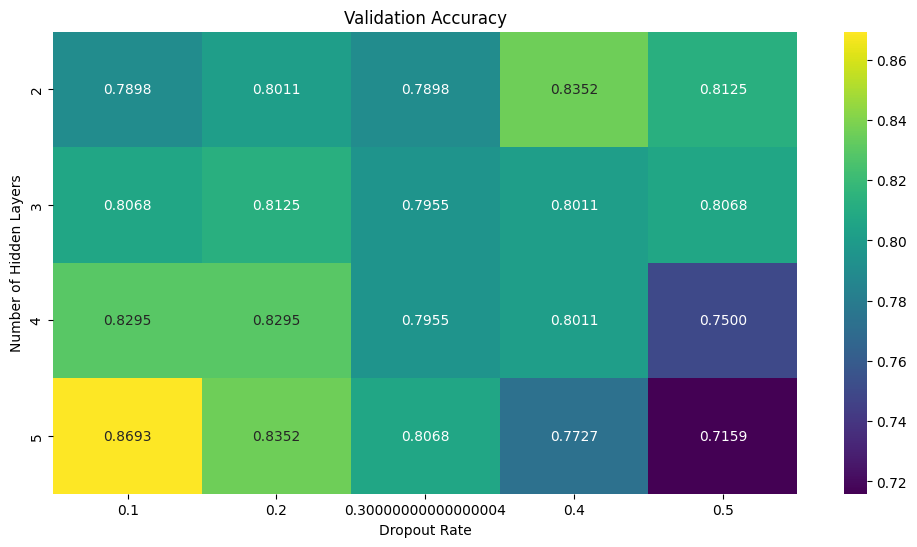

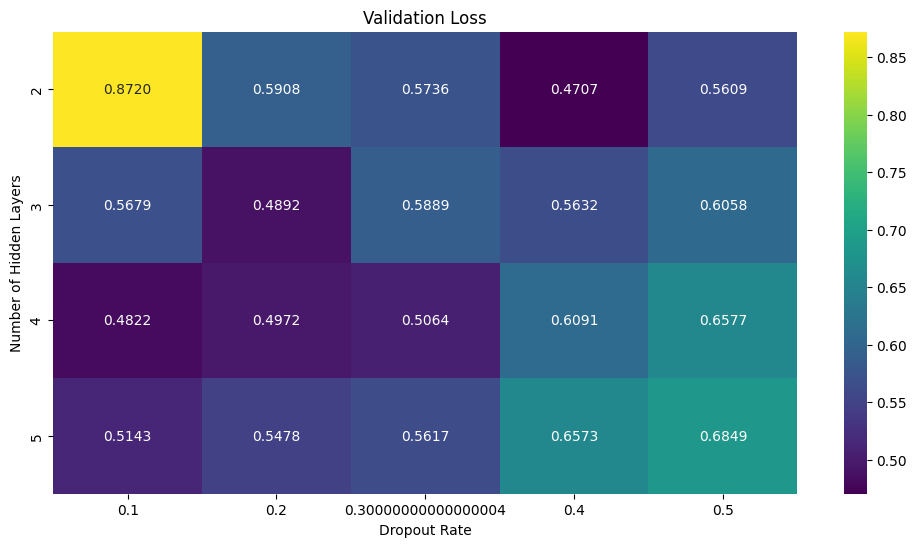

Best CNN Hidden Layers: 2
Best CNN Dropout Rate: 0.4


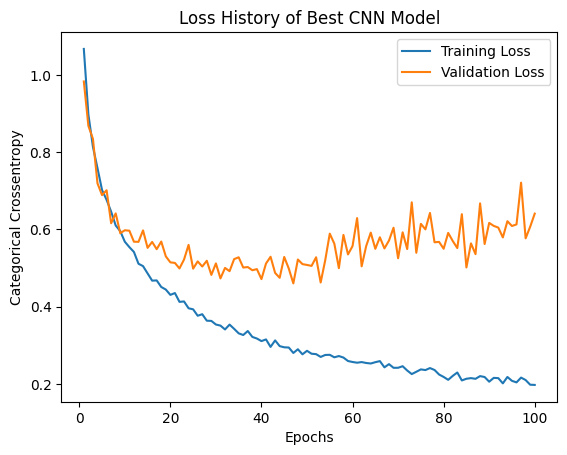

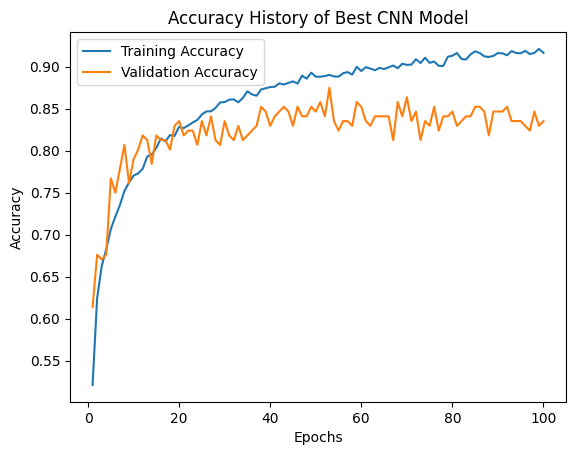

50/50 [==============================] - 0s 4ms/step - loss: 0.7388 - accuracy: 0.8019
Best CNN Model Test Loss: 0.7387568950653076
Best CNN Model Test Accuracy: 0.8019047379493713
50/50 [==============================] - 0s 2ms/step
Best CNN Model Ancillary Results
Precision: 0.8060
Recall: 0.8019
F1-Score: 0.8022
50/50 [==============================] - 0s 2ms/step
Classification Report for Best CNN Model:
              precision    recall  f1-score   support

        Bach       0.94      0.92      0.93       626
   Beethoven       0.76      0.70      0.73       446
      Chopin       0.66      0.58      0.62       118
      Mozart       0.68      0.80      0.73       385

    accuracy                           0.80      1575
   macro avg       0.76      0.75      0.75      1575
weighted avg       0.81      0.80      0.80      1575



In [7]:
# Grid Search Training Loop
dropout_values = np.linspace(0.1, 0.5, 5)
hidden_layer_values = [2, 3, 4, 5]

val_accuracies = np.zeros((len(hidden_layer_values), len(dropout_values)))
val_losses = np.zeros((len(hidden_layer_values), len(dropout_values)))

best_model = None
best_loss = 1000
best_training_history = None
best_settings = None

for i, hidden_layers in enumerate(hidden_layer_values):
    for j, dropout_rate in enumerate(dropout_values):
        print(f"Training Dropout: {dropout_rate} Hidden Layer: {hidden_layers}")
        model, val_acc, val_loss, train_history = train_cnn_model(dropout_rate, hidden_layers, epochs=SEARCH_EPOCHS)
        
        val_accuracies[i, j] = val_acc
        val_losses[i, j] = val_loss
        
        if val_loss < best_loss:
            best_model = model
            best_loss = val_loss
            best_training_history = train_history
            best_settings = (hidden_layers, dropout_rate)
            
# Heatmap for Validation Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Heatmap for validation loss
plt.figure(figsize=(12, 6))
sns.heatmap(val_losses, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Retrain model on the best settings

hidden_layers, dropout_rate = best_settings
print(f"Best CNN Hidden Layers: {hidden_layers}")
print(f"Best CNN Dropout Rate: {dropout_rate}")
best_model, _, _, best_training_history = train_cnn_model(dropout_rate, hidden_layers, epochs=FULL_EPOCHS)

train_loss = best_training_history.history["loss"]
val_loss = best_training_history.history["val_loss"]

train_acc = best_training_history.history["accuracy"]
val_acc = best_training_history.history["val_accuracy"]

plt.plot(range(1,FULL_EPOCHS+1), train_loss, label="Training Loss")
plt.plot(range(1,FULL_EPOCHS+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")
plt.legend()
plt.title("Loss History of Best CNN Model")
plt.show()

plt.plot(range(1,FULL_EPOCHS+1), train_acc, label="Training Accuracy")
plt.plot(range(1,FULL_EPOCHS+1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History of Best CNN Model")
plt.show()

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best CNN Model Test Loss: {test_loss}")
print(f"Best CNN Model Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Best CNN Model Ancillary Results")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
print("Classification Report for Best CNN Model:")
print(report)

## Discussion of CNN model training
For the convolutional network, it seemed less was more. The network with the least hidden layers and most regularization was able to produce the best results on the validation data when trained for 20 epochs. Though 20 epochs may be somewhat of a small number of training steps, the models seem to hit close to their maximum validation accuracy after a few epochs anyways. The large amount of dropout needed for performance on the validation set is probably due to the fact the model has access to a limited amount of data, so 40% dropout for 2 hidden layers removes enough units for generalization to the validation set. Our group hypothesizes that a larger amount of epochs may slightly change the result, but the settings used to optimize the CNN are probably sufficient.

Notice how the CNN's validation loss seems to diverge from the training loss when given 100 epochs instead of 20 to train. This indicates the architecture's inability to generalize the data, which is worrying for such a large dropout. The inability to generalize would suggest the use of an alternative architecture or more advanced hyperparameter tuning.

## LSTM Methodology
We will follow the exact same procedure for tuning and training the LSTM. Again, our group decided to limit the hyperparameter tuning to the two vital parameters of hidden layer number and dropout rate.

After optimizing the LSTM model we will compare the results to the CNN architecture for this dataset.

In [8]:
def train_lstm_model(dropout, hidden_layers, epochs=20):
    lstm = model_api.opt2_lstm(4, hidden_layers, dropout_rate=dropout, max_len=100)
    history = lstm.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=1024, verbose=0)

    val_accuracy = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]

    return lstm, val_accuracy, val_loss, history

Training Dropout: 0.1 Hidden Layer: 2
Training Dropout: 0.2 Hidden Layer: 2
Training Dropout: 0.30000000000000004 Hidden Layer: 2
Training Dropout: 0.4 Hidden Layer: 2
Training Dropout: 0.5 Hidden Layer: 2
Training Dropout: 0.1 Hidden Layer: 3
Training Dropout: 0.2 Hidden Layer: 3
Training Dropout: 0.30000000000000004 Hidden Layer: 3
Training Dropout: 0.4 Hidden Layer: 3
Training Dropout: 0.5 Hidden Layer: 3
Training Dropout: 0.1 Hidden Layer: 4
Training Dropout: 0.2 Hidden Layer: 4
Training Dropout: 0.30000000000000004 Hidden Layer: 4
Training Dropout: 0.4 Hidden Layer: 4
Training Dropout: 0.5 Hidden Layer: 4
Training Dropout: 0.1 Hidden Layer: 5
Training Dropout: 0.2 Hidden Layer: 5
Training Dropout: 0.30000000000000004 Hidden Layer: 5
Training Dropout: 0.4 Hidden Layer: 5
Training Dropout: 0.5 Hidden Layer: 5


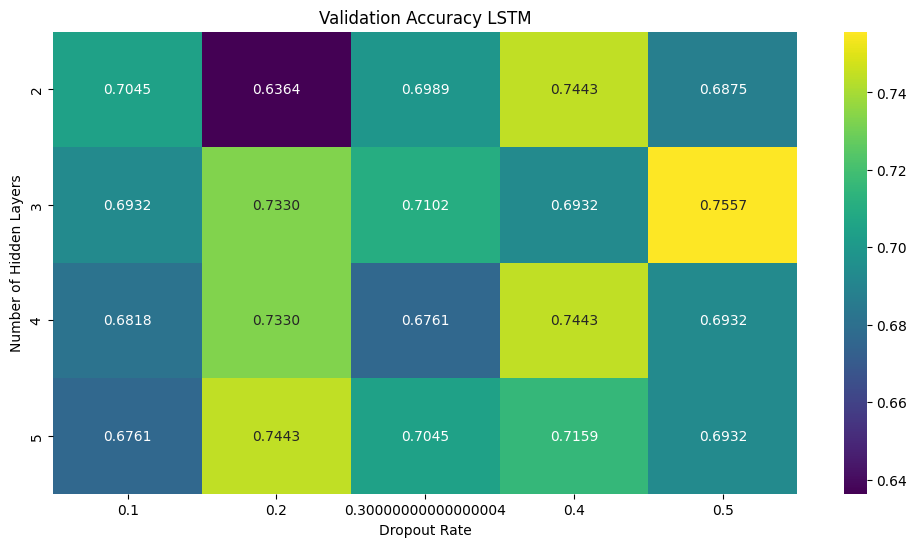

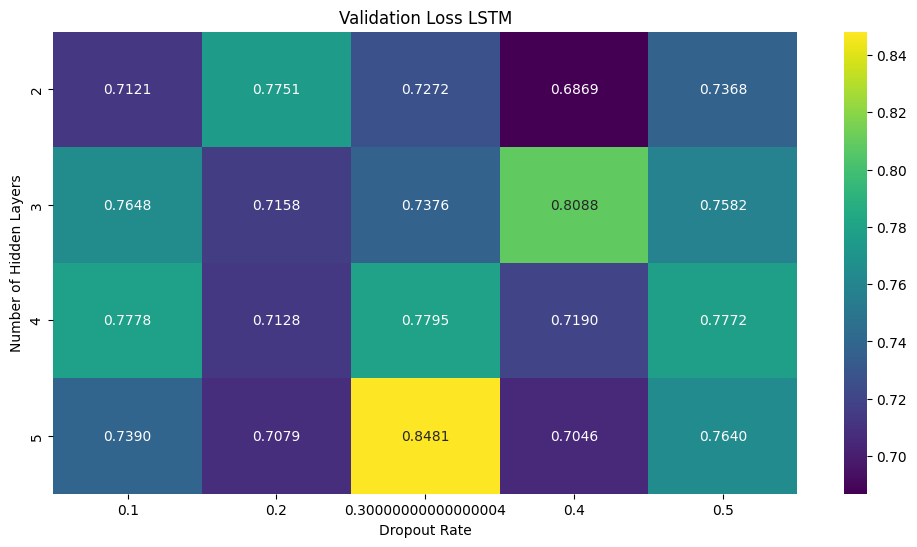

Best LSTM Hidden Layers: 2
Best LSTM Dropout Rate: 0.4


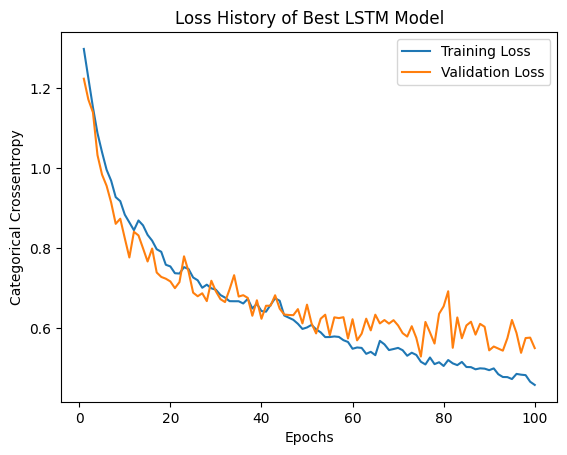

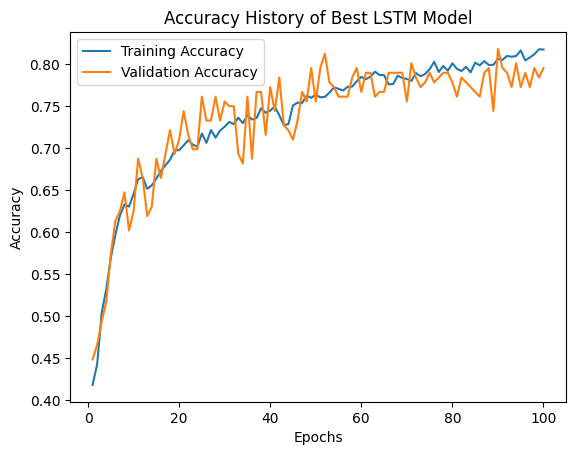

50/50 [==============================] - 1s 15ms/step - loss: 0.6053 - accuracy: 0.7721
Best LSTM Model Test Loss: 0.6053071022033691
Best LSTM Model Test Accuracy: 0.7720634937286377
50/50 [==============================] - 2s 15ms/step
Best LSTM Model Ancillary Results
Precision: 0.7718
Recall: 0.7721
F1-Score: 0.7707
50/50 [==============================] - 1s 15ms/step
Classification Report for Best LSTM Model:
              precision    recall  f1-score   support

        Bach       0.88      0.92      0.90       626
   Beethoven       0.77      0.68      0.72       446
      Chopin       0.61      0.58      0.60       118
      Mozart       0.65      0.70      0.68       385

    accuracy                           0.77      1575
   macro avg       0.73      0.72      0.72      1575
weighted avg       0.77      0.77      0.77      1575



In [9]:
# Grid Search Training Loop
dropout_values = np.linspace(0.1, 0.5, 5)
hidden_layer_values = [2, 3, 4, 5]

val_accuracies = np.zeros((len(hidden_layer_values), len(dropout_values)))
val_losses = np.zeros((len(hidden_layer_values), len(dropout_values)))

best_model = None
best_loss = 1000
best_training_history = None
best_settings = None

for i, hidden_layers in enumerate(hidden_layer_values):
    for j, dropout_rate in enumerate(dropout_values):
        print(f"Training Dropout: {dropout_rate} Hidden Layer: {hidden_layers}")
        model, val_acc, val_loss, train_history = train_lstm_model(dropout_rate, hidden_layers, epochs=SEARCH_EPOCHS)

        val_accuracies[i, j] = val_acc
        val_losses[i, j] = val_loss

        if val_loss < best_loss:
            best_model = model
            best_loss = val_loss
            best_training_history = train_history
            best_settings = (hidden_layers, dropout_rate)

# Heatmap for Validation Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Accuracy LSTM')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Heatmap for validation loss
plt.figure(figsize=(12, 6))
sns.heatmap(val_losses, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Loss LSTM')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Retrain model on the best settings
EPOCHS = 100
hidden_layers, dropout_rate = best_settings
print(f"Best LSTM Hidden Layers: {hidden_layers}")
print(f"Best LSTM Dropout Rate: {dropout_rate}")

best_model, _, _, best_training_history = train_lstm_model(dropout_rate, hidden_layers, epochs=FULL_EPOCHS)

train_loss = best_training_history.history["loss"]
val_loss = best_training_history.history["val_loss"]

train_acc = best_training_history.history["accuracy"]
val_acc = best_training_history.history["val_accuracy"]

plt.plot(range(1,FULL_EPOCHS+1), train_loss, label="Training Loss")
plt.plot(range(1,FULL_EPOCHS+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")
plt.legend()
plt.title("Loss History of Best LSTM Model")
plt.show()

plt.plot(range(1,FULL_EPOCHS+1), train_acc, label="Training Accuracy")
plt.plot(range(1,FULL_EPOCHS+1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History of Best LSTM Model")
plt.show()

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best LSTM Model Test Loss: {test_loss}")
print(f"Best LSTM Model Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Best LSTM Model Ancillary Results")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
print("Classification Report for Best LSTM Model:")
print(report)

## Discussion of LSTM model training
The LSTM model seems to thrive best at less hidden layers and a higher dropout rate just like the CNN. Analysis of the accuracy heatmaps would suggest the LSTM realizes similar performance at varying hidden layer lengths with the optimal dropout rate is found. Moreover, it seems the higher hidden layer count actually needs lower dropout rates to realize performance, this may be due to the 20 epoch constraint used in the hyperparameter tuning. The 20 epoch constraint is hard to increase due to computational limitations of our desktops, however, the heatmap seems to indicate that the settings used for the LSTM should be sufficient.

## PrettyMIDI Model Results

The overall metrics for performance indicate that the Convolutional Neural Network was able to achieve a higher accuracy and lower loss than the LSTM model. This is further showcased in the overall Precision, Recall, and F1-Scores, as the CNN performs better than the LSTM in all of them. 

The Classification Reports produced for both models indicate that both perform well at identifying compositions and scores created by Bach. The same can also be true for compositions and scores created by Beethoven and Mozart. The Chopin labels have mixed results, the CNN has much higher precision but slightly lower recall than the LSTM. Chopin is the smallest class in the test set and the dataset, so the gap in precision indicates the CNN's ability to better generalize on a small amount of data. However, the final training of the tuned hyperparameter models tells a different story for both architectures. Though the LSTM is unable to achieve the level of performance of the CNN, the model has a much more stable validation loss and accuracy that moves in tandem with the training metrics. The CNN, on the other hand, diverges from its validation loss and accuracy very quickly. Our group hypothesizes that the LSTM may be more suitable to these temporally related music tasks, making the architecture generalize to the validation set more easily.

In conclusion, the CNN seems to be able to outperform the LSTM architecture in this context. Our group finds this surprising as the LSTM in theory should be more suited to time-series prediction. Perhaps the small dataset of less than ten thousand examples doesn’t create the proper environment for the more complex LSTM cell parameters.

# Train Neural Networks on audio files.

## Dataset Creation

The audio data is a much larger dataset. In order to accomodate RAM limitations, our group split each song into at most 10 (100 timestep, 140 feature) chunks. These chunks are randomly sampled throughout the song and are contiguous to keep the integrity of the time-series aspect of the data

In [10]:
import os
import numpy as np
from tqdm import tqdm
# Import Pretty MIDI data
audio_data_folder = "AudioData/Archive/"

examples = []
labels = []

for file_name in tqdm(os.listdir(audio_data_folder)):
    if file_name.endswith('.npz'): # Grab .npz files in this huge folder
        file_path = os.path.join(audio_data_folder, file_name)
        data = np.load(file_path)
        
        keys = list(data.keys())
        
        example = []
        for key in keys:
            features = data[key]
            example.append(features)
        
        example = np.reshape(np.array(example), (-1, 140))
        examples.append(example)

100%|██████████████████████████████████████████████████████████████████████████████| 1635/1635 [01:47<00:00, 15.19it/s]


In [11]:
# Define the size of the chunks
samples = []

npz_labels = np.load("PreprocessedMidis/y_labels.npz")
label_keys = list(npz_labels.keys())
labels = []

def audio_chunks(example_array, chunk_size = (100, 140)):
    sampled_chunks = []
    example_length = example_array.shape[0]
    num_full_chunks = (example_length - chunk_size[0]) // chunk_size[0] + 1
    
     # Extract full chunks
    for i in range(num_full_chunks):
        start_idx = i * chunk_size[0]
        end_idx = start_idx + chunk_size[0]
        chunk = example[start_idx:end_idx, :]
        sampled_chunks.append(chunk)
    
    # Handle the last chunk if it’s not full-sized
    if example_length % chunk_size[0] != 0:
        last_chunk_start = num_full_chunks * chunk_size[0]
        last_chunk = example[last_chunk_start:, :]
        # Zero-pad the last chunk if necessary
        if last_chunk.shape[0] < chunk_size[0]:
            padding_needed = chunk_size[0] - last_chunk.shape[0]
            padded_last_chunk = np.pad(last_chunk, ((0, padding_needed), (0, 0)), mode='constant')
            sampled_chunks.append(padded_last_chunk)
        else:
            sampled_chunks.append(last_chunk)
    
    return sampled_chunks


num_chunks_to_sample = 10
for l_key, example in zip(label_keys, examples): # Sample 100 timesteps from each example
    all_chunks = audio_chunks(example)
    label_value = npz_labels[l_key]
    
    if len(all_chunks) > num_chunks_to_sample: # Random sampling of the audio samples.
        sampled_chunk_indices = np.random.choice((len(all_chunks)),
                                         num_chunks_to_sample, replace=False)
        
        sampled_chunks = [all_chunks[i] for i in sampled_chunk_indices]
    else:
        sampled_chunks = all_chunks
    
    for chunk in sampled_chunks:
        samples.append(chunk)
        labels.append(label_value)

samples = np.array(samples)
labels = np.array(labels)
print(samples.shape)
print(labels.shape)

(16350, 100, 140)
(16350, 4)


Notice the Raw Audio Dataset is double the size of the previous dataset PrettyMIDI Dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=1)

print(f"Training Set Size: {X_train.shape}")
print(f"Validation Set Size: {X_val.shape}")
print(f"Test Set Size: {X_test.shape}")

print(f"Training Label Size: {y_train.shape}")
print(f"Validation Label Size: {y_val.shape}")
print(f"Test Label Size: {y_test.shape}")

Training Set Size: (13080, 100, 140)
Validation Set Size: (327, 100, 140)
Test Set Size: (2943, 100, 140)
Training Label Size: (13080, 4)
Validation Label Size: (327, 4)
Test Label Size: (2943, 4)


## 1D CNN Training
The audio data is a flattened mel spectrogram by timestep, this means we can no longer take advantage of the spatial relationships in 2 dimensions. However, our group used 1-dimensional kernels to still exploit the possible 1-dimensional temporal relationships found across time vectors. The same procedure for optimizing the hyperparameters of network depth and dropout rate will be applied to this model as well.

In [13]:
def train_cnn_audio(dropout, hidden_layers, epochs=20):
    cnn = model_api.audio_cnn(100, 4, hidden_layers, dropout_rate=dropout)
    history = cnn.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=128, verbose=0)
    
    val_accuracy = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
                               
    return cnn, val_accuracy, val_loss, history

Training Dropout: 0.1 Hidden Layer: 2
Training Dropout: 0.2 Hidden Layer: 2
Training Dropout: 0.30000000000000004 Hidden Layer: 2
Training Dropout: 0.4 Hidden Layer: 2
Training Dropout: 0.5 Hidden Layer: 2
Training Dropout: 0.1 Hidden Layer: 3
Training Dropout: 0.2 Hidden Layer: 3
Training Dropout: 0.30000000000000004 Hidden Layer: 3
Training Dropout: 0.4 Hidden Layer: 3
Training Dropout: 0.5 Hidden Layer: 3
Training Dropout: 0.1 Hidden Layer: 4
Training Dropout: 0.2 Hidden Layer: 4
Training Dropout: 0.30000000000000004 Hidden Layer: 4
Training Dropout: 0.4 Hidden Layer: 4
Training Dropout: 0.5 Hidden Layer: 4
Training Dropout: 0.1 Hidden Layer: 5
Training Dropout: 0.2 Hidden Layer: 5
Training Dropout: 0.30000000000000004 Hidden Layer: 5
Training Dropout: 0.4 Hidden Layer: 5
Training Dropout: 0.5 Hidden Layer: 5


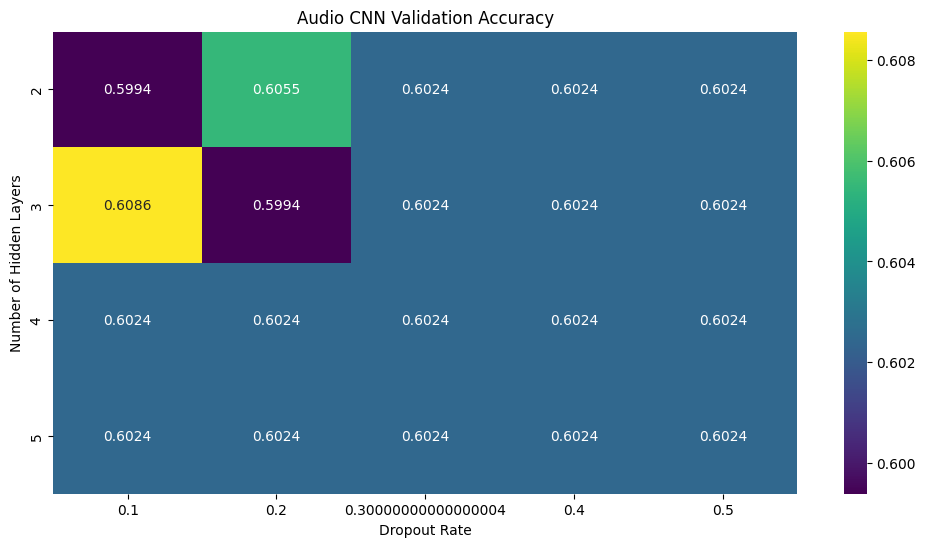

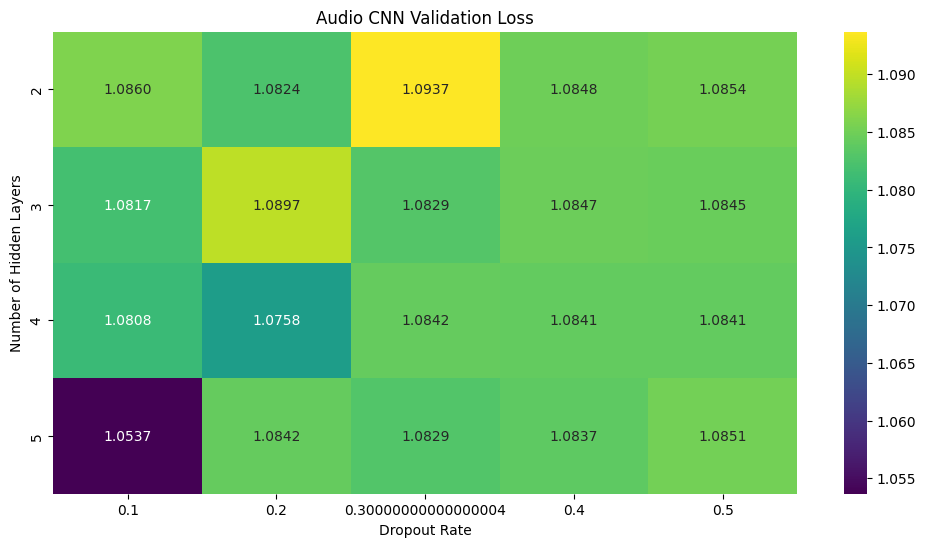

Best Audio CNN Hidden Layers: 5
Best Audio CNN Dropout Rate: 0.1


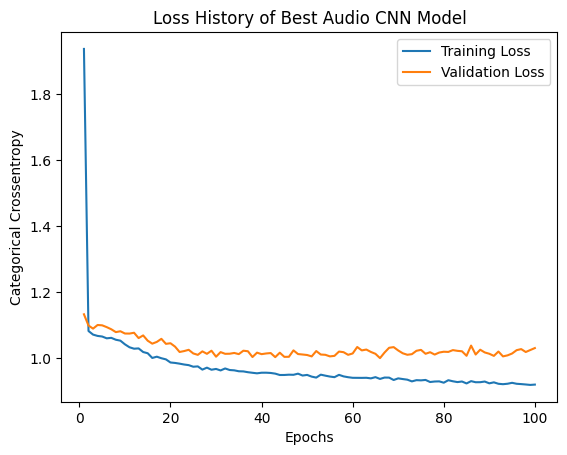

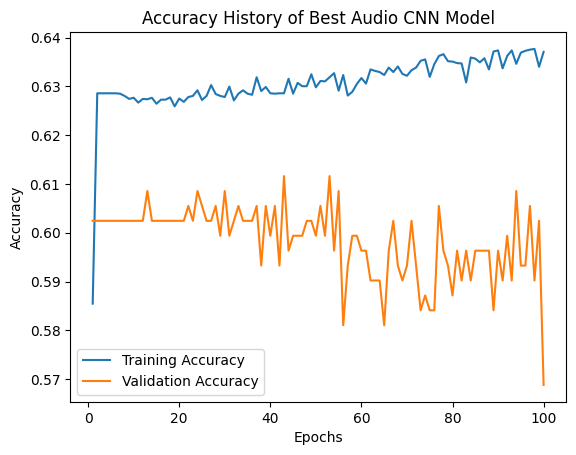

92/92 [==============================] - 1s 5ms/step - loss: 0.9612 - accuracy: 0.6235
Best Audio CNN Model Test Loss: 0.9612488150596619
Best Audio CNN Model Test Accuracy: 0.623513400554657
92/92 [==============================] - 0s 3ms/step
Best Audio CNN Model Ancillary Results
Precision: 0.5230
Recall: 0.6235
F1-Score: 0.5273
15/92 [===>..........................] - ETA: 0s

Z:\MiniConda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 0s 3ms/step
Classification Report for Best Audio CNN Model:
              precision    recall  f1-score   support

        Bach       0.64      0.95      0.77      1821
   Beethoven       0.43      0.05      0.09       403
      Chopin       0.00      0.00      0.00       258
      Mozart       0.42      0.19      0.26       461

    accuracy                           0.62      2943
   macro avg       0.37      0.30      0.28      2943
weighted avg       0.52      0.62      0.53      2943



Z:\MiniConda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\MiniConda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\MiniConda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Grid Search Training Loop
dropout_values = np.linspace(0.1, 0.5, 5)
hidden_layer_values = [2, 3, 4, 5]

val_accuracies = np.zeros((len(hidden_layer_values), len(dropout_values)))
val_losses = np.zeros((len(hidden_layer_values), len(dropout_values)))

best_model = None
best_loss = 1000
best_training_history = None
best_settings = None

for i, hidden_layers in enumerate(hidden_layer_values):
    for j, dropout_rate in enumerate(dropout_values):
        print(f"Training Dropout: {dropout_rate} Hidden Layer: {hidden_layers}")
        model, val_acc, val_loss, train_history = train_cnn_audio(dropout_rate, hidden_layers, epochs=SEARCH_EPOCHS)
        
        val_accuracies[i, j] = val_acc
        val_losses[i, j] = val_loss
        
        if val_loss < best_loss:
            best_model = model
            best_loss = val_loss
            best_training_history = train_history
            best_settings = (hidden_layers, dropout_rate)
            
# Heatmap for Validation Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Audio CNN Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Heatmap for validation loss
plt.figure(figsize=(12, 6))
sns.heatmap(val_losses, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Audio CNN Validation Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Retrain model on the best settings
EPOCHS = 100
hidden_layers, dropout_rate = best_settings
print(f"Best Audio CNN Hidden Layers: {hidden_layers}")
print(f"Best Audio CNN Dropout Rate: {dropout_rate}")
best_model, _, _, best_training_history = train_cnn_audio(dropout_rate, hidden_layers, epochs=FULL_EPOCHS)

train_loss = best_training_history.history["loss"]
val_loss = best_training_history.history["val_loss"]

train_acc = best_training_history.history["accuracy"]
val_acc = best_training_history.history["val_accuracy"]

plt.plot(range(1,FULL_EPOCHS+1), train_loss, label="Training Loss")
plt.plot(range(1,FULL_EPOCHS+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")
plt.legend()
plt.title("Loss History of Best Audio CNN Model")
plt.show()

plt.plot(range(1,FULL_EPOCHS+1), train_acc, label="Training Accuracy")
plt.plot(range(1,FULL_EPOCHS+1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History of Best Audio CNN Model")
plt.show()

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Audio CNN Model Test Loss: {test_loss}")
print(f"Best Audio CNN Model Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Best Audio CNN Model Ancillary Results")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
print("Classification Report for Best Audio CNN Model:")
print(report)

## Discussion of 1D CNN Audio Model Training

The Audio data produced by the mel spectrogram and chroma techniques proves to be much harder to extract usable features from. The best model's validation and training loss indicate the architecture's inability to learn the data in a meaningful manner. The accuracy history graph is the most telling as the accuracy is actually lower on the 100th epoch of training compared to the first few! This makes sense, the audio data does not nearly have as much curated and engineered features that are known to differentiate musical compositions. Even worse, the test data seems to indicate that the CNN cannot identify a single example (out of 258) of Chopin.

## LSTM Training
The LSTM for this dataset will be trained in the same manner as the last three models.

In [15]:
def train_lstm_audio(dropout, hidden_layers, epochs=20):
    lstm = model_api.audio_lstm(4, hidden_layers, dropout_rate=dropout, max_len=100)
    history = lstm.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=1024, verbose=0)
    
    val_accuracy = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
                               
    return lstm, val_accuracy, val_loss, history

Training Dropout: 0.1 Hidden Layer: 2
Training Dropout: 0.2 Hidden Layer: 2
Training Dropout: 0.30000000000000004 Hidden Layer: 2
Training Dropout: 0.4 Hidden Layer: 2
Training Dropout: 0.5 Hidden Layer: 2
Training Dropout: 0.1 Hidden Layer: 3
Training Dropout: 0.2 Hidden Layer: 3
Training Dropout: 0.30000000000000004 Hidden Layer: 3
Training Dropout: 0.4 Hidden Layer: 3
Training Dropout: 0.5 Hidden Layer: 3
Training Dropout: 0.1 Hidden Layer: 4
Training Dropout: 0.2 Hidden Layer: 4
Training Dropout: 0.30000000000000004 Hidden Layer: 4
Training Dropout: 0.4 Hidden Layer: 4
Training Dropout: 0.5 Hidden Layer: 4
Training Dropout: 0.1 Hidden Layer: 5
Training Dropout: 0.2 Hidden Layer: 5
Training Dropout: 0.30000000000000004 Hidden Layer: 5
Training Dropout: 0.4 Hidden Layer: 5
Training Dropout: 0.5 Hidden Layer: 5


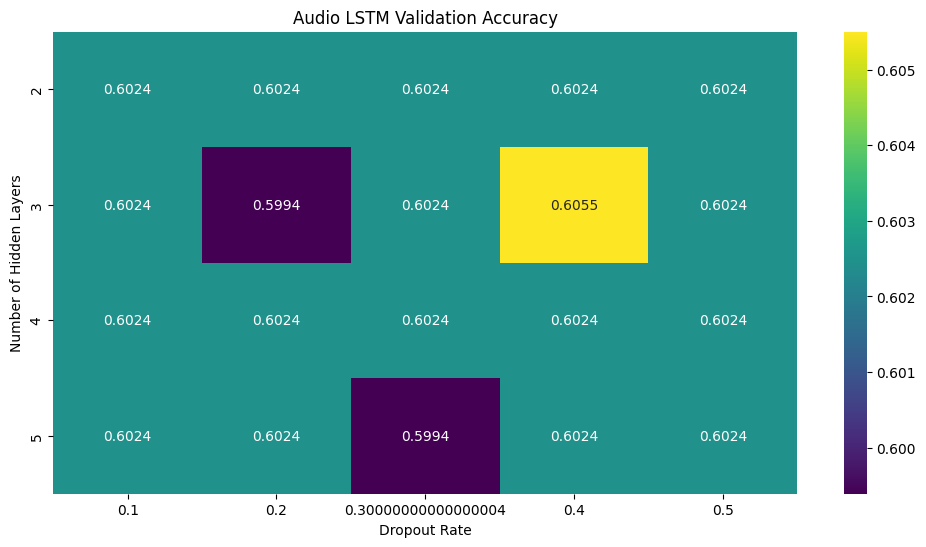

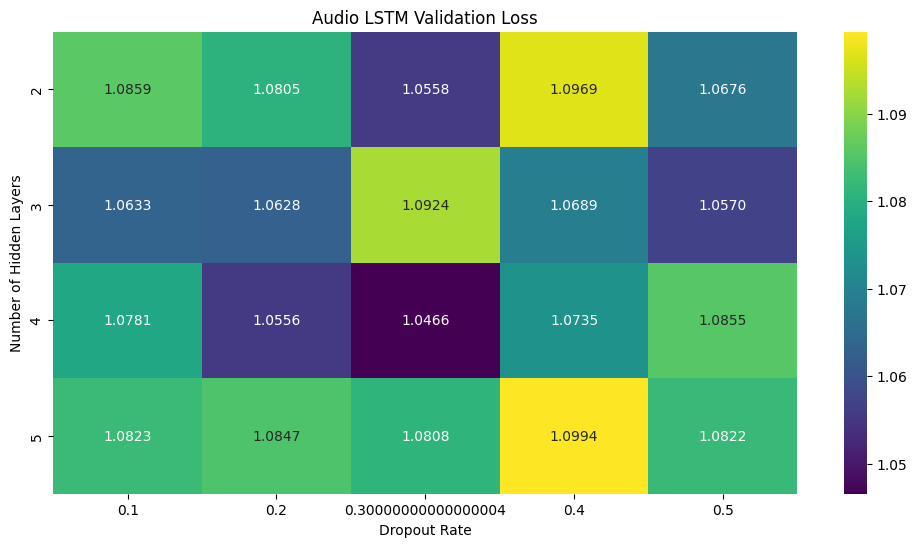

Best Audio LSTM Hidden Layers: 4
Best Audio LSTM Dropout Rate: 0.30000000000000004


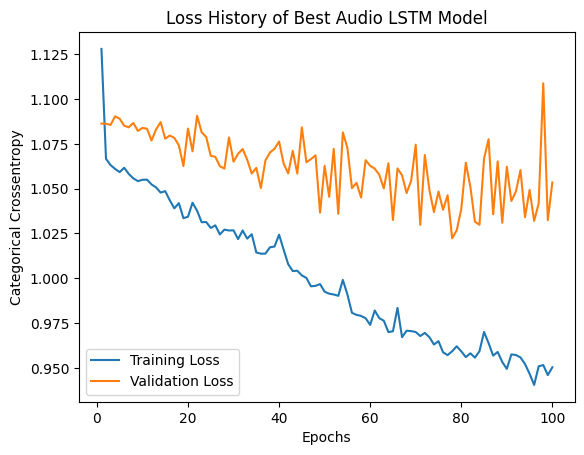

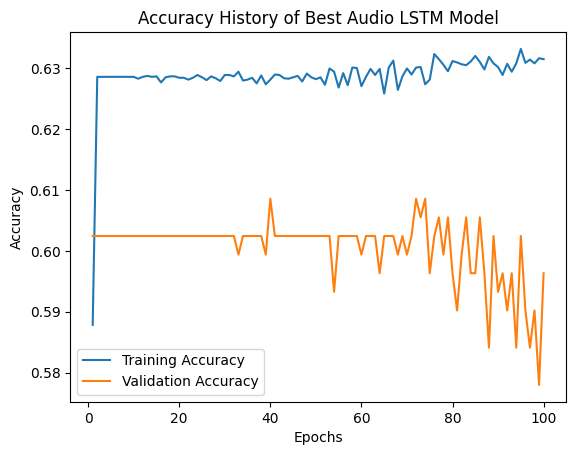

92/92 [==============================] - 2s 24ms/step - loss: 0.9848 - accuracy: 0.6150
Best Audio LSTM Model Test Loss: 0.984798014163971
Best Audio LSTM Model Test Accuracy: 0.6150186657905579
92/92 [==============================] - 4s 24ms/step
Best Audio LSTM Model Ancillary Results
Precision: 0.4304
Recall: 0.6150
F1-Score: 0.4844
 1/92 [..............................] - ETA: 4s

Z:\MiniConda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92/92 [==============================] - 2s 24ms/step
Classification Report for Best Audio LSTM Model:
              precision    recall  f1-score   support

        Bach       0.62      0.98      0.76      1821
   Beethoven       0.33      0.06      0.10       403
      Chopin       0.00      0.00      0.00       258
      Mozart       0.00      0.00      0.00       461

    accuracy                           0.62      2943
   macro avg       0.24      0.26      0.21      2943
weighted avg       0.43      0.62      0.48      2943



Z:\MiniConda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\MiniConda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\MiniConda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Grid Search Training Loop
dropout_values = np.linspace(0.1, 0.5, 5)
hidden_layer_values = [2, 3, 4, 5]

val_accuracies = np.zeros((len(hidden_layer_values), len(dropout_values)))
val_losses = np.zeros((len(hidden_layer_values), len(dropout_values)))

best_model = None
best_loss = 1000
best_training_history = None
best_settings = None

for i, hidden_layers in enumerate(hidden_layer_values):
    for j, dropout_rate in enumerate(dropout_values):
        print(f"Training Dropout: {dropout_rate} Hidden Layer: {hidden_layers}")
        model, val_acc, val_loss, train_history = train_lstm_audio(dropout_rate, hidden_layers, epochs=SEARCH_EPOCHS)
        
        val_accuracies[i, j] = val_acc
        val_losses[i, j] = val_loss
        
        if val_loss < best_loss:
            best_model = model
            best_loss = val_loss
            best_training_history = train_history
            best_settings = (hidden_layers, dropout_rate)
            
# Heatmap for Validation Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Audio LSTM Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Heatmap for validation loss
plt.figure(figsize=(12, 6))
sns.heatmap(val_losses, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Audio LSTM Validation Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Retrain model on the best settings
hidden_layers, dropout_rate = best_settings
print(f"Best Audio LSTM Hidden Layers: {hidden_layers}")
print(f"Best Audio LSTM Dropout Rate: {dropout_rate}")
best_model, _, _, best_training_history = train_lstm_audio(dropout_rate, hidden_layers, epochs=FULL_EPOCHS)

train_loss = best_training_history.history["loss"]
val_loss = best_training_history.history["val_loss"]

train_acc = best_training_history.history["accuracy"]
val_acc = best_training_history.history["val_accuracy"]

plt.plot(range(1,FULL_EPOCHS+1), train_loss, label="Training Loss")
plt.plot(range(1,FULL_EPOCHS+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")
plt.legend()
plt.title("Loss History of Best Audio LSTM Model")
plt.show()

plt.plot(range(1,FULL_EPOCHS+1), train_acc, label="Training Accuracy")
plt.plot(range(1,FULL_EPOCHS+1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History of Best Audio LSTM Model")
plt.show()

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Audio LSTM Model Test Loss: {test_loss}")
print(f"Best Audio LSTM Model Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Best Audio LSTM Model Ancillary Results")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
print("Classification Report for Best Audio LSTM Model:")
print(report)

## Discussion of LSTM End-to-End model training
The LSTM seems to produce even worse results than the CNN for training on the raw audio dataset. This dataset, again, proves to be very difficult for a model to adapt to a fairly simple classification task. The loss matrices barely tell a difference in hyperparameter performances, suggesting that the lack of data may be a huge factor in this problem. Notice how the LSTM fails to classify any examples from two classes!

## Conclusion

The objective of our final project was to compare two common methods found in the field of Deep Learning, End-to-End Learning and Domain Expertise. The PrettyMIDI dataset represented a set a features designed by an "expert" as it is composed of common music theory concepts to describe the classical music compositions. The Raw Audio dataset, as its name suggests, only contains mel spectrogram and other raw forms of audio processing to extract features from the musical compositions. 

The engineered features proved to be signficantly easier to use for both architectures; in fact, the gap between the datasets is huge. Our group believes that the results stress, despite the power behind new Deep Learning techniques,  the importance of an engineer's ability to extract useful, well-known features for even the most simple problems. The task for this project is a simple classification task with only four classes. Even so, the raw audio data models consistently failed to identify a whole class (two classes in the case of the LSTM), despite a dataset of double the size. Engineered Features that use expert knowledge of the problem domain are the best machine learning models.

Our project showcases the interchangability of architectures on simple classification problems. Despite LSTMs being designed for long time sequence problems, the CNNs in this project (1-dimesional and 2-dimensional) both outperformed their LSTM rivals. With a well implemented hyperparameter tuning scheme, a machine learning engineer shouldn't worry too much about the semantics and fine-details of a model. The single greatest factor for the success of a Deep Learning problem is not necessarily model complexity, hyperparameter settings, nor even dataset size, but feature quality and domain expertise.

# References

Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural Computation, 9(8), 1735–1780. https://doi.org/10.1162/neco.1997.9.8.1735 

Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2017). ImageNet classification with deep convolutional Neural Networks. Communications of the ACM, 60(6), 84–90. https://doi.org/10.1145/3065386 

Liashchynskyi, Petro & Liashchynskyi, Pavlo. (2019). Grid Search, Random Search,Genetic Algorithm: A Big Comparison for NAS. 